In [16]:
## In this notebook we will fit our GRU NN model and evaluate our results versus
# a validation set

import numpy as np
np.random.seed(666)
import pandas as pd
import csv
import pickle as pic
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import roc_curve, auc
from sklearn.externals import joblib


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback, ModelCheckpoint


import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('inputs/train.csv')
test = pd.read_csv('inputs/test.csv')



X_train = train["comment_text"].fillna("fillna").values
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_test = test["comment_text"].fillna("fillna").values

max_features = 50000
maxlen = 150
embed_size = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train) + list(X_test))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [8]:
joblib.dump( tokenizer, "inputs/NN_tokenizer.sav" )
joblib.dump( x_train, "inputs/x_train.sav" )
joblib.dump( x_test, "inputs/x_test.sav" )

['inputs/x_test.sav']

In [ ]:
tokenizer = joblib.load("inputs/NN_tokenizer.sav")
x_train = joblib.load("inputs/x_train.sav")
x_test = joblib.load("inputs/x_test.sav")

In [9]:
embedding_path = 'inputs/glove.840B.300d.txt'
embeddings = pd.read_table(embedding_path, sep=" ", index_col=0, header=None,
                           quoting=csv.QUOTE_NONE)
emb_mean, emb_std = np.mean(embeddings.values), np.std(embeddings.values)

print(emb_mean)

-0.00583849066868932


In [10]:
from datetime import datetime
now = datetime.now()

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))

p = 0
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = None
    if (word in embeddings.index) == True: embedding_vector = embeddings.loc[word]
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector.as_matrix()
    p = p + 1
    if p % 5000 == 0:
        print(word)
        


disgusting
persecuted
ks
chow
caravan
sidetracked
bedfordshire
envelopes
fittings


In [21]:
joblib.dump(embedding_matrix,"inputs/embeddings.sav")

['inputs/embeddings.sav']

In [4]:
embedding_matrix = joblib.load("embeddings.sav")

In [5]:
def get_model():
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(6, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()

    return model

model = get_model()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 300)     15000000    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 150, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 150, 160)     182880      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
global_ave

In [6]:
weights = joblib.load("Model_W/glove_80_D2_LR001_F50.hdf5")
model.set_weights(weights)

In [7]:
def get_callbacks(filepath):
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [msave]



class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [9]:
batch_size = 32
epochs = 2

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95, 
                                              random_state=233)



RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)
#callbacks = get_callbacks(filepath=file_path)


#model.load_weights(filepath=file_path)

#hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, 
#                 validation_data=(X_val, y_val),
#                 callbacks=[RocAuc])

In [23]:
file_path = "Model_W/glove_80_D2_LR001_F50.hdf5"
#model.save_weights(filepath=file_path)

joblib.dump(model.get_weights(),file_path)

['Model_W/glove_80_D2_LR001_F50.hdf5']

In [25]:
#y_tra

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [10]:
train_pred_all = model.predict(X_tra, batch_size=600, verbose=1)

91058/91058 [==============================] - 125s 1ms/step


In [13]:
train_pred_all = pd.DataFrame(train_pred_all,columns = class_names)

In [20]:
print(X_tra.shape)
print(train_pred_all.head())
print(train_pred_all.shape)
print(pd.DataFrame(y_tra).head())
y_train = pd.DataFrame(y_tra,columns=class_names)
joblib.dump(train_pred_all,"inputs/GRU_NN_predictions_train.sav")
joblib.dump(y_train,"inputs/y_labels_train.sav")

(91058, 150)
      toxic  severe_toxic   obscene    threat    insult  identity_hate
0  0.016410      0.000206  0.006556  0.000307  0.006210       0.000707
1  0.009405      0.000025  0.003139  0.000234  0.002544       0.000267
2  0.000251      0.000008  0.000458  0.000011  0.000242       0.000018
3  0.000298      0.000011  0.000257  0.000012  0.000170       0.000010
4  0.003035      0.000038  0.002120  0.000472  0.001543       0.000049
(91058, 6)
   0  1  2  3  4  5
0  0  0  0  0  0  0
1  0  0  0  0  0  0
2  0  0  0  0  0  0
3  0  0  0  0  0  0
4  0  0  0  0  0  0


['inputs/y_labels_train.sav']

In [12]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

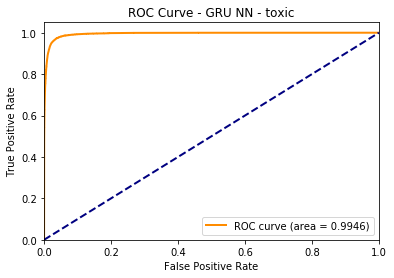

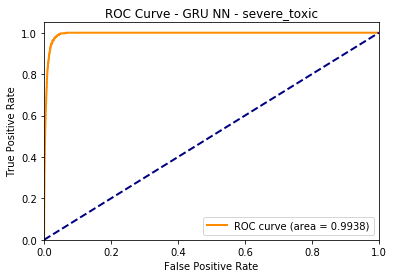

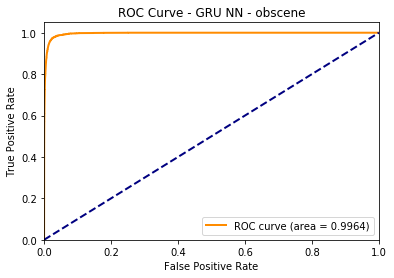

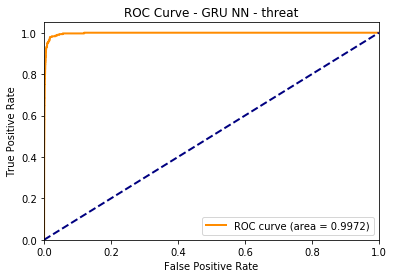

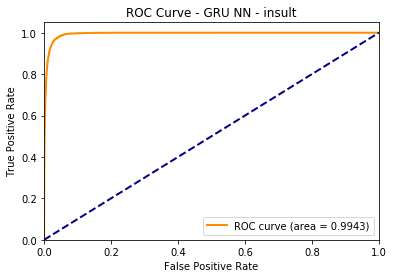

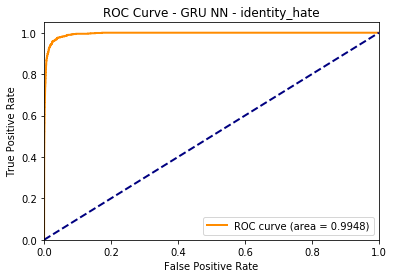

In [45]:

# Plot ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_name in class_names:
    filename = "Model_W/"+class_name+"_GRU.sav"
    
    train_target = y_train[class_name]
    train_pred = train_pred_all[class_name]

    fpr[class_name], tpr[class_name], _ = roc_curve(train_target, train_pred)
    roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])
    
    plt.figure()
    lw=2
    plt.plot(fpr[class_name], tpr[class_name], color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[class_name])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - GRU NN - {0}'.format(class_name))
    plt.legend(loc="lower right")
    plt.savefig('Plots/ROC_GRU_{0}.png'.format(class_name))
    plt.show()

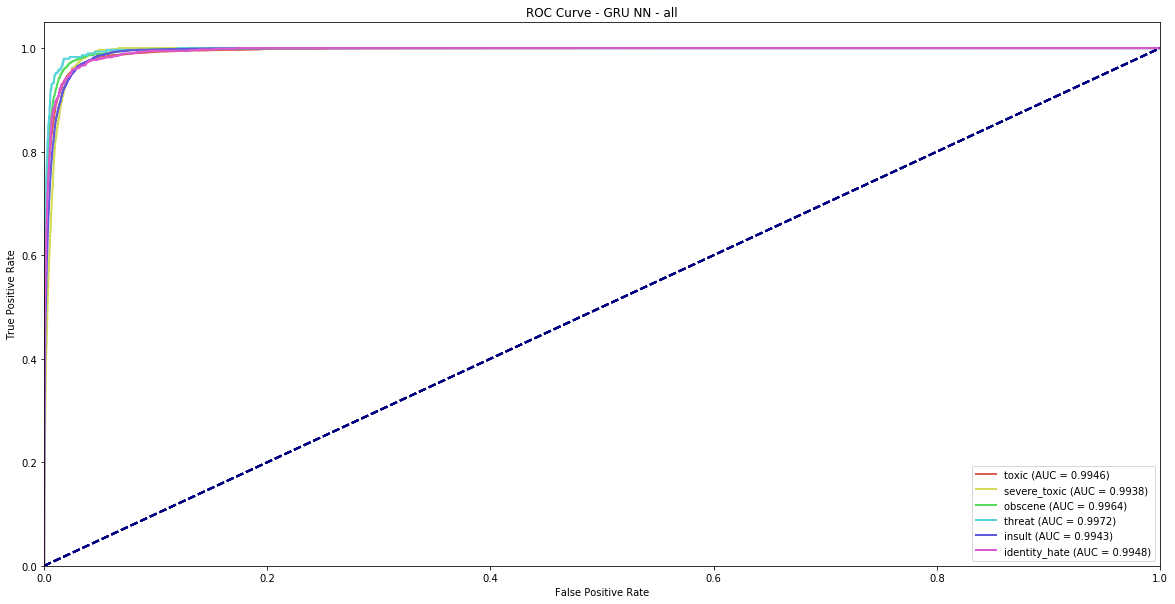

In [18]:
# Plot ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()

colors = sns.color_palette("hls",6)

plt.figure(figsize=(20,10))
for idx, class_name in enumerate(class_names):
    #filename = "Model_W/"+class_name+"_GRU.sav"
    
    train_target = y_train[class_name]
    train_pred = train_pred_all[class_name]

    fpr[class_name], tpr[class_name], _ = roc_curve(train_target, train_pred)
    roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])
    
    lw=2
    plt.plot(fpr[class_name], tpr[class_name], color=colors[idx],
         lw=lw, label='%s (AUC = %0.4f)' % (class_name,roc_auc[class_name]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - GRU NN - all')
    plt.legend(loc="lower right")

plt.savefig('Plots/ROC_GRU_all.png')
plt.show()

In [ ]:
y_pred = model.predict(x_test, batch_size=600, verbose=1)

In [16]:
submission = pd.read_csv('inputs/sample_submission.csv')
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [17]:
submission[["toxic", "severe_toxic", "obscene","threat",
                         "insult", "identity_hate"]] = pd.DataFrame(y_pred)
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.992737,0.675259,0.979341,0.067553,0.920044,0.133756
1,0000247867823ef7,0.000337,0.000007,0.000124,0.000018,0.000116,0.000016
2,00013b17ad220c46,0.001146,0.000023,0.000303,0.000013,0.000170,0.000047
3,00017563c3f7919a,0.000252,0.000005,0.000134,0.000011,0.000082,0.000007
4,00017695ad8997eb,0.002492,0.000044,0.000471,0.000081,0.000345,0.000041


In [18]:
submission.to_csv("./submissions/glove_v1.csv", index=False)